# Siren Exploration

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt
import cv2

import time

In [2]:
# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: mps


In [3]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [4]:
def get_mgrid_2d(height, width, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    width: int (number of points along x-axis)
    height: int (number of points along y-axis)
    dim: int'''
    
    if dim != 2:
        raise ValueError("This function currently supports only 2D grids.")

    x = torch.linspace(-1, 1, steps=width)
    y = torch.linspace(-1, 1, steps=height)
    
    mgrid = torch.stack(torch.meshgrid(y, x, indexing="ij"), dim=-1)  # Ensure correct indexing
    mgrid = mgrid.reshape(-1, dim)
    
    return mgrid

Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

In [5]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

And finally, differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.

In [6]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

# Experiments

In [7]:
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img.to(device)

In [8]:
def get_image_tensor(image_path, H, W):
    img = Image.open(image_path) 
    transform = Compose([
        Resize((H, W)), 
        ToTensor(),
    ])
    img = transform(img)
    img = img * 2. - 1.  
    
    return img.to(device)

(702, 1020, 3)


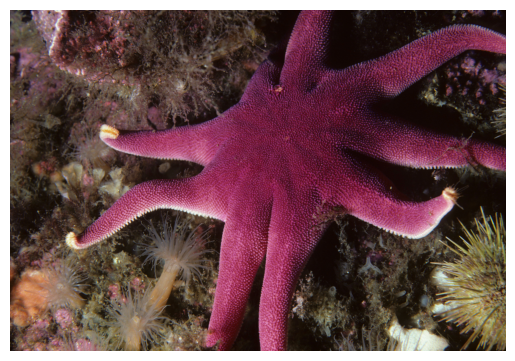

In [9]:
image_path = './data/DIV2K_train_HR/0001.png'

# Read the image
img = Image.open(image_path)
new_size = (img.width // 2, img.height // 2)
img = img.resize(new_size, Image.LANCZOS)
H, W, C = np.shape(img)
print(np.shape(img))

# Display the image
plt.imshow(img)
plt.axis("off")  # Hide axis
plt.show()


<a id='section_1'></a>
## Fitting an image

First, let's simply fit that image!

We seek to parameterize a greyscale image $f(x)$ with pixel coordinates $x$ with a SIREN $\Phi(x)$.

That is we seek the function $\Phi$ such that:
$\mathcal{L}=\int_{\Omega} \lVert \Phi(\mathbf{x}) - f(\mathbf{x}) \rVert\mathrm{d}\mathbf{x}$
 is minimized, in which $\Omega$ is the domain of the image.

We write a little datast that does nothing except calculating per-pixel coordinates:

In [10]:
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        # img = get_cameraman_tensor(sidelength)
        image_path = './data/DIV2K_train_HR/0001.png'
        
        img = get_image_tensor(image_path, H, W)
        print(img.shape)
        self.pixels = img.permute(1, 2, 0).contiguous().view(-1, 3)
        self.coords = get_mgrid_2d(H, W, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

Let's instantiate the dataset and our Siren. As pixel coordinates are 2D, the siren has 2 input features, and since the image is grayscale, it has one output channel.

In [11]:
img_size = 512
cameraman = ImageFitting(img_size)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=3, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
img_siren.to(device)

torch.Size([3, 702, 1020])


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

We now fit Siren in a simple training loop. Within only hundreds of iterations, the image and its gradients are approximated well.

Step 0, Total loss 0.368349


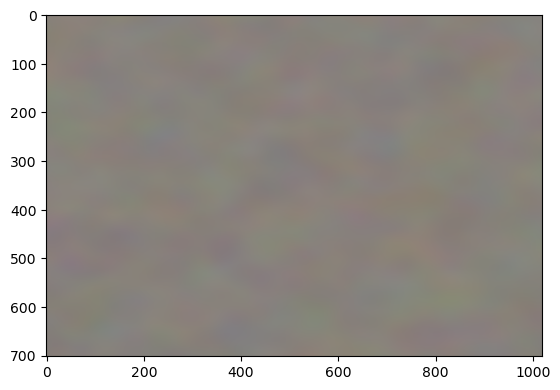

KeyboardInterrupt: 

In [12]:
total_steps = 5000 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 250

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.to(device), ground_truth.to(device)

for step in range(total_steps):
    model_output, coords = img_siren(model_input)
    loss = ((model_output - ground_truth)**2).mean()

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        with torch.no_grad():
            # img_grad = gradient(model_output, coords)
            # img_laplacian = laplace(model_output, coords)
    
            output_view = model_output.view(H, W, 3)
            output_view = torch.clamp(output_view, -1, 1) * 0.5 + 0.5
            output_view = (output_view * 255).to(torch.uint8).cpu().detach().numpy()
            
            plt.imshow(output_view)
            plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

## Test the trained model with higher resolution coordinates

In [17]:
save_folder = 'siren_fitting_results'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)  

In [ ]:
with torch.no_grad():
    coords = get_mgrid_2d(H, W, 2).unsqueeze(0).cuda()
    model_output, _ = img_siren(coords)
    output_view = model_output.view(H, W, 3)
    output_view = torch.clamp(output_view, -1, 1) * 0.5 + 0.5
    output_view = (output_view * 255).to(torch.uint8).cpu().detach().numpy()
    plt.imshow(output_view)
    plt.show()
    cv2.imwrite(os.path.join(save_folder, 'org_size.png'), output_view[:, :, ::-1])
    

In [ ]:
with torch.no_grad():
    target_H = H * 2
    target_W = W * 2
    coords = get_mgrid_2d(target_H, target_W, 2).unsqueeze(0).cuda()
    model_output, _ = img_siren(coords)
    output_view = model_output.view(target_H, target_W, 3)
    output_view = torch.clamp(output_view, -1, 1) * 0.5 + 0.5
    output_view = (output_view * 255).to(torch.uint8).cpu().detach().numpy()
    plt.imshow(output_view)
    plt.show()
    cv2.imwrite(os.path.join(save_folder, 'double_size.png'), output_view[:, :, ::-1])
    

In [41]:
import gc
gc.collect()  # Collect garbage to free up memory
torch.cuda.empty_cache()  # Clear CUDA cache 

In [ ]:
with torch.no_grad():
    target_H = int(H * 2.5)
    target_W = int(W * 2.5)
    coords = get_mgrid_2d(target_H, target_W, 2).unsqueeze(0).cuda()
    model_output, _ = img_siren(coords)
    output_view = model_output.view(target_H, target_W, 3)
    output_view = torch.clamp(output_view, -1, 1) * 0.5 + 0.5
    output_view = (output_view * 255).to(torch.uint8).cpu().detach().numpy()
    plt.imshow(output_view)
    plt.show()
    cv2.imwrite(os.path.join(save_folder, 'HW2.5_size.png'), output_view[:, :, ::-1])
    del output_view

# Code for coordinate augmentation

In [ ]:

class ImageImplicit(Dataset):
    def __init__(self, paths, image_size, n_samples_per_image, device="cpu"):
        super().__init__()

        self.paths = paths
        self.image_size = image_size
        self.n_samples_per_image = n_samples_per_image
        self.device = device

        self._load_images()


    @torch.no_grad()
    def _load_images(self):

        images = [imageio.imread(path) for path in self.paths]
        images = [cv2.resize(image, self.image_size) for image in images]
        images = np.stack(images, axis=0)
        images = torch.from_numpy(images).to(self.device)
        images = images.permute(0, 3, 1, 2)
        images = images / 255.
        images = images * 2. - 1.
        self.images = images

    def __len__(self):
        return 1000000000

    @torch.no_grad()
    def __getitem__(self, index):

        N = len(self.images)
        np.random.seed(index)

        coordinates = np.random.uniform(size=[2, self.n_samples_per_image]).astype(np.float32)
        coordinates = torch.from_numpy(coordinates).to(self.device) * 2. - 1.
        coordinates = coordinates.unsqueeze(0).repeat(N, 1, 1)

        coordinates_bi = coordinates.unsqueeze(2).permute(0, 2, 3, 1)
        rgb = F.grid_sample(self.images, coordinates_bi, mode='bilinear', align_corners=True)

        coordinates = coordinates.squeeze(2)
        rgb = rgb.squeeze(2)

        return {"query": coordinates, "gt": rgb}

# TODO: 
- Incorporate the above code into dataloader.
- Incorporate neighborhood pixel values as conditions (like LIIF) for fitting a single image.
- Try the above method in training a single network for fitting many different images.
- Add GAN loss.